# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr

In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import sintela_to_datetime, open_sintela_file, local_earthquake_quicklook
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame

ERROR 1: PROJ: proj_create_from_database: Open of /home/velgueta/.conda/envs/python-obspy/share/proj failed


### Get a list of events from USGS

In [2]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime.now(),
                minmagnitude=3.0,
                maxradiuskm=500, 
                latitude=47.60, 
                longitude=-122.33)

print("Returned %s events" % len(events))
 

Returned 13 events


In [3]:
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['time'],ascending=False)
event_df
#event_df.iloc[0::]

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
12,us7000ishe,2022-11-26 03:50:17.627,"Vancouver Island, Canada region",49.276600,-126.099400,34.283,4.90,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,527
11,uw61886506,2022-10-07 12:52:36.010,"16 km ESE of Lacomb, Oregon",44.540333,-122.550833,13.170,4.39,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,896
10,us6000ipd3,2022-09-29 15:09:32.565,off the coast of Washington,47.637400,-128.921800,10.555,3.30,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,168
9,uw61882431,2022-09-22 14:41:56.900,"26 km WNW of Forks, Washington",48.046500,-124.715000,37.040,3.49,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,190
8,uw61869652,2022-09-08 08:08:25.830,"7 km WNW of Lofall, Washington",47.842000,-122.751667,23.330,3.71,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,592
7,uw61862977,2022-08-13 13:31:22.900,"21 km NW of Bickleton, Washington",46.130333,-120.500000,12.100,3.05,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,146
6,us6000iac9,2022-08-12 20:00:04.319,"148 km W of Yachats, Oregon",44.483100,-125.947500,10.000,4.00,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,246
5,us6000i90r,2022-08-08 07:38:56.410,"201 km W of Tofino, Canada",48.973600,-128.652200,10.000,4.60,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,326
4,uw61860022,2022-08-04 13:22:39.400,"6 km SSE of Black Diamond, Washington",47.258667,-121.971833,21.540,3.06,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,250
3,uw61836427,2022-05-28 19:07:44.030,"55 km NE of Marblemount, Washington",48.807833,-120.822500,-0.060,3.16,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,157


### Choose an event to analyze

In [13]:
#detected_quakes = ['uw61835766','uw61832097','uw61836427',
                 #  'uw61846212','uw61819867','uw61850651','uw61855012']
#detected_quakes_whidbey = ['nc73821036','uw61819867','uw61855012','us7000gxl1']

#this_event_index = 0
#this_id=detected_quakes[this_event_index]

this_id = 'uw61835766'

this_event = event_df[event_df.id==this_id]
t0 = this_event['time'].iloc[0]

this_event

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
0,uw61835766,2022-05-01 11:15:56.460,"2 km E of Mount Vernon, Washington",48.4235,-122.3055,13.54,3.56,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,424


In [5]:
print(t0)

2022-05-17 08:07:34.400000


### Load the DAS Data

In [14]:
# cable = 'seadasn'
cable = 'whidbey'
record_length = 10 #minutes

if cable == 'seadasn':
    prefix = 'seadasn'
    network_name = 'SeaDAS-N'
    if t0 < datetime.datetime(2022, 6, 20, 0, 0, 0):
        datastore='/data/data0/seadasn_2022-03-17_2022-06-20/'
    else:
        datastore='/data/data7/seadasn/'
        
elif cable == 'whidbey':
    prefix = 'whidbey'
    network_name='Whidbey-DAS'
    datastore = '/data/data5/Converted/'

data,dates,attrs = open_sintela_file(prefix,
                                     t0,
                                     datastore,
                                     number_of_files=record_length,
                                     verbose=True)
x_max=data.shape[1] * attrs['SpatialSamplingInterval']

Searching for files matching: /data/data5/Converted/whidbey_2022-05-01_11-15*h5


ValueError: Why are there ZERO files? That shouldn't be possible!

In [7]:
low_cut = 2
hi_cut = 10

b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
data_filt = filtfilt(b,a,data,axis=0)

In [8]:
client = Client("IRIS")

t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
dt = datetime.timedelta(minutes=record_length)
t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )

st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
# st.decimate(5, strict_length=False, no_filter=False) #everything should be at 40Hz now
st2 = client.get_waveforms("IU", "COR", "00", "HH1", t1, t2, attach_response=True)

pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
st.remove_response(output='VEL', pre_filt=pre_filt)
st2.remove_response(output='VEL', pre_filt=pre_filt)

1 Trace(s) in Stream:
IU.COR.00.HH1 | 2022-05-17T08:07:34.008393Z - 2022-05-17T08:17:33.998393Z | 100.0 Hz, 60000 samples

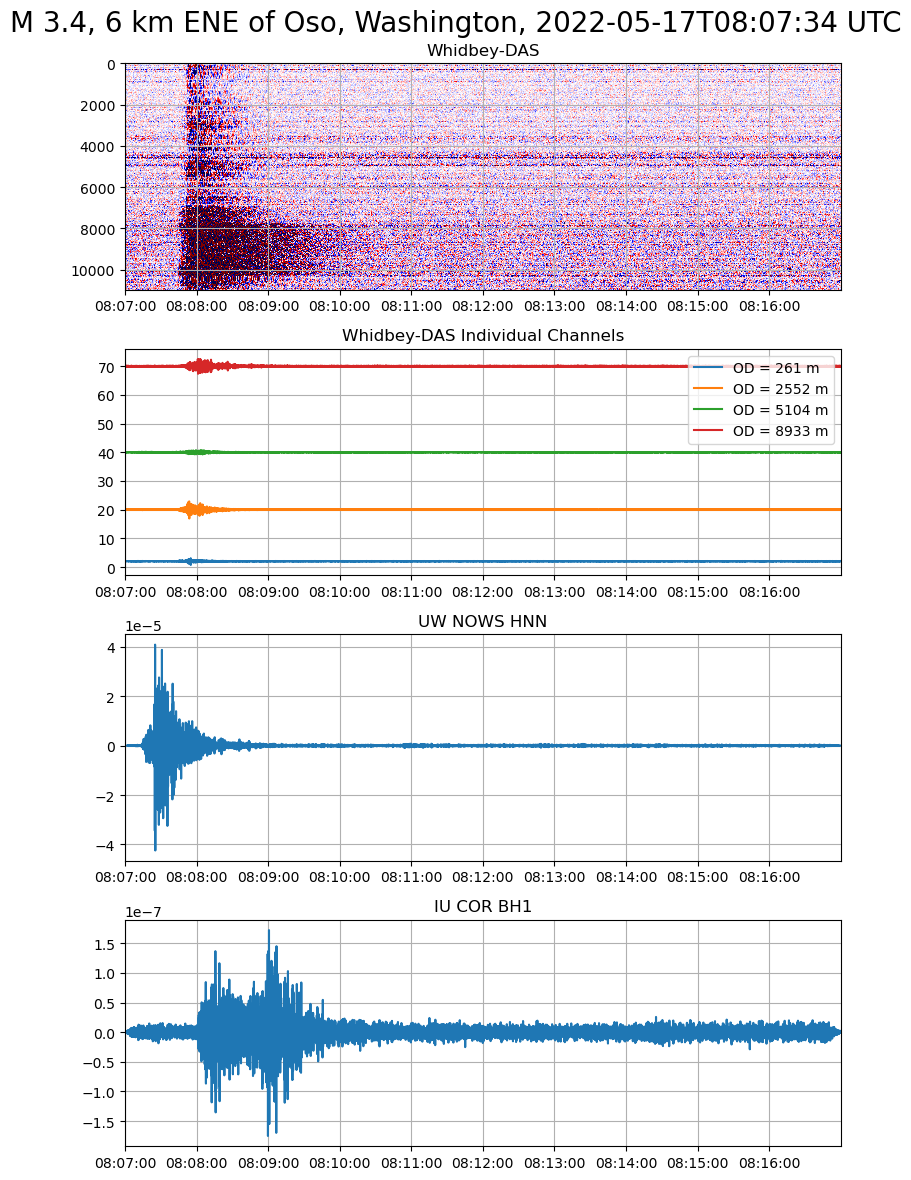

In [9]:
# nombre = f"figures/{event_df.iloc[catalog_index]['Evid']}.png"
# local_earthquake_quicklook(dates,data_filt,st,st2,x_max,event_df,catalog_index,filename=nombre)


stitle=f"M {this_event['magnitude'].to_numpy()[0]}, "\
       f"{this_event['location'].to_numpy()[0]}, "\
       f"{str(this_event['time'].to_numpy()[0])[0:-10]} UTC"


local_earthquake_quicklook(dates,data_filt,st,st2,x_max,
                           stitle,das_vmax=0.02,
                           network_name=network_name)


In [10]:
this_event.url.to_list()[0]

'https://earthquake.usgs.gov/earthquakes/eventpage/uw61832097'

In [11]:
# from tqdm import tqdm
# xc = np.zeros((2*18000-1,174))

# for i in tqdm(range(174)):
#     xc[:,i] = np.correlate( data_filt[:,30]/max(data_filt[:,30]),
#                             data_filt[:,i*10]/max(data_filt[:,i*10]),
#                             mode='full')

In [12]:
from tqdm import tqdm
xc = np.zeros((2*18000-1,174))

for i in tqdm(range(174)):
    xc[:,i] = np.correlate(np.sign(data_filt[:,30]),
                           np.sign(data_filt[:,i*10]),
                           mode='full')

  0%|          | 0/174 [00:01<?, ?it/s]


ValueError: could not broadcast input array from shape (119999,) into shape (35999,)

In [ ]:
fig,ax=plt.subplots()
plt.imshow(xc.T,aspect='auto',vmin=-1000,vmax=1000)
# plt.plot(data_filt[:,30])
# plt.plot(data_filt[:,40])
plt.xlim(18000-1e3,18000+1e3)
plt.show()

In [ ]:
fig,ax=plt.subplots()
# plt.imshow(xc.T,aspect='auto',vmin=-0.1,vmax=0.1)
plt.plot(data_filt[:,40])
plt.plot(data_filt[:,30],alpha=0.5)
plt.xlim(6000,8000)
plt.show()